## Garbage Classification Models: Evaluation


## Imports and Configuration

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, Subset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR
from torchvision.models.efficientnet import EfficientNet_B0_Weights
import os
import re
import logging
import sys
import numpy as np
from collections import Counter
from transformers import DistilBertModel, DistilBertTokenizer
import wandb
from sklearn.model_selection import StratifiedKFold, train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import time
import torch.nn.functional as F

# ========================================= GLOBAL CONFIGURATION ================================================
# Data Directories
DATA_DIR = "C:/Users/Auste/Documents/kfold_garbage_data"
CLASSES = ["Black", "Blue", "Green", "TTR"]

# ========================================= Data Settings =========================================
IMAGE_SIZE = (224, 224)  # Input image size for EfficientNetV2-S
NUM_CLASSES = 4  # Number of output classes for classification
MAX_LEN = 40  # Maximum token length for DistilBERT tokenizer
TEST_SIZE = 0.2  # Test dataset size split
K_FOLDS = 5  # Number of folds for stratified k-fold cross-validation

# ========================================= Training Hyperparameters =========================================
BATCH_SIZE = 64  # Number of samples per batch
GRAD_ACCUM_STEPS = 4
EPOCHS = 50  # Maximum number of training epochs
DROPOUT_IMAGE = 0.2 # Reduce from 0.3
DROPOUT_TEXT = 0.1 # Reduce from 0.2
DROPOUT_FUSION = 0.2 
DROPOUT_CLASSIFIER = 0.1
PATIENCE = 10  # Number of epochs to wait before early stopping
CONVERGENCE_THRESHOLD = 0.001  # Minimum improvement in validation loss to continue training

# ========================================= Optimization Settings =========================================
OPTIMIZER = "AdamW"
LR_SCHEDULING_FACTOR = 0.3
LEARNING_RATE_UNFREEZE_IMAGE = 1e-5
LEARNING_RATE_UNFREEZE_TEXT = 1e-5
LEARNING_RATE_FUSION = 1e-3
LEARNING_RATE_CLASSIFIER = 5e-3
LEARNING_RATE_IMAGE = 0.001 # # EfficientNetB0
LEARNING_RATE_TEXT = 0.00002 # DistilBERT Uncased
WEIGHT_DECAY_TEXT = 1e-3  # Reduce from 1e-2
WEIGHT_DECAY_IMAGE = 1e-4  # Reduce from 1e-3
WEIGHT_DECAY_FUSION = 4e-4 
WEIGHT_DECAY_CLASSIFIER = 1e-3  # Reduce from 1e-4
LABEL_SMOOTHING_PREDICTION = 0.05 # Reduce from 0.1

# ========================================= System Settings =========================================
NUM_WORKERS = 4  # Dataloader parallelization

# Normalization Stats
NORMALIZATION_STATS = EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()

## Helper Function

In [72]:
def read_text_files_with_labels_and_image_paths(path):
    """Extract text from file names, apply preprocessing, and return labels with image paths."""
    texts, labels, image_paths = [], [], []
    class_folders = sorted(os.listdir(path))
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = sorted(os.listdir(class_path))  # Sort to ensure order consistency
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    # Extract filename without extension
                    file_name_no_ext, _ = os.path.splitext(file_name)

                    # Replace underscores with spaces
                    text = file_name_no_ext.replace("_", " ")

                    # Remove numbers
                    text_without_digits = re.sub(r"\d+", "", text)

                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])
                    image_paths.append(file_path)

    return np.array(texts), np.array(labels), np.array(image_paths)

## Load Data

In [73]:
logging.info("[INFO] Extracting text, labels, and image paths...")
texts, labels, image_paths= read_text_files_with_labels_and_image_paths(DATA_DIR)

## Dataset Classes

In [74]:
class CustomTextDataset(Dataset):
    """Dataset class for text data."""
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }
    
# Custom dataset class for images
class ImageDataset(Dataset):
    """Dataset class for image data."""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)



class MultimodalDataset(Dataset):
    """Dataset class for multimodal data (image + text)."""
    def __init__(self, image_dataset, text_dataset):
        self.image_dataset = image_dataset
        self.text_dataset = text_dataset

    def __len__(self):
        return min(len(self.image_dataset), len(self.text_dataset))

    def __getitem__(self, idx):
        image, label = self.image_dataset[idx]
        text_data = self.text_dataset[idx]
        return {
            "image": image,
            "input_ids": text_data["input_ids"],
            "attention_mask": text_data["attention_mask"],
            "label": label
        }

### Model Definition

In [75]:
class MultimodalClassifier(nn.Module):
    """Multimodal model combining EfficientNetB0 and DistilBERT with Transformer-based fusion."""
    def __init__(self, num_classes):
        super(MultimodalClassifier, self).__init__()

        # ----------- Image Feature Extractor (EfficientNetB0) -----------
        self.image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Freeze all layers except the last one
        for param in self.image_model.features.parameters():
            param.requires_grad = False
        for param in self.image_model.features[-1:].parameters():  # Unfreeze last feature layer
            param.requires_grad = True

        num_ftrs = self.image_model.classifier[1].in_features
        self.image_model.classifier = nn.Identity()  # Remove classifier
        self.image_fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(DROPOUT_IMAGE)  # Use global dropout for image features
        )

        # ----------- Text Feature Extractor (DistilBERT) -----------
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze all layers except the last transformer layer
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.text_model.transformer.layer[-1:].parameters():  # Unfreeze last transformer layer
            param.requires_grad = True

        self.text_fc = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(DROPOUT_TEXT)  # Use global dropout for text features
        )

        # ----------- Normalize Features -----------
        self.text_norm = nn.LayerNorm(256)
        self.image_norm = nn.LayerNorm(256)

        # ----------- Transformer Fusion -----------
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,  # Match the feature dimension
            nhead=8,       # Number of attention heads
            dim_feedforward=1024,  # Feedforward dimension
            dropout=DROPOUT_FUSION,   # Use global dropout for fusion
            activation="gelu",  # Use GELU activation
            norm_first=True  # Enable layer normalization
        )
        self.transformer_fusion = nn.TransformerEncoder(
            encoder_layer,
            num_layers=4  # Number of encoder layers
        )

        # ----------- Fusion Layers -----------
        self.fusion_fc = nn.Sequential(
            nn.Linear(256, 512),  # Increase dimension
            nn.BatchNorm1d(512),  # Add batch normalization
            nn.GELU(),            # Use GELU activation

            nn.Linear(512, 256),  # Intermediate layer
            nn.BatchNorm1d(256),  # Batch normalization
            nn.GELU(),            # GELU activation

            nn.Linear(256, 128),  # Reduce dimension
            nn.BatchNorm1d(128),  # Batch normalization
            nn.GELU(),            # GELU activation
        )

        # ----------- Classifier Layer -----------
        self.classifier = nn.Linear(128, num_classes)  # Final output layer

        self.dropout = nn.Dropout(DROPOUT_PREDICTION)  # Use global dropout for prediction

    def forward(self, input_ids, attention_mask, image_inputs):
        # Extract text features
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_output.last_hidden_state[:, 0, :])
        text_features = self.text_norm(text_features)

        # Extract image features
        image_features = self.image_fc(self.image_model(image_inputs))
        image_features = self.image_norm(image_features)

        # Combine image and text features into a single sequence
        combined = torch.cat((image_features.unsqueeze(1), text_features.unsqueeze(1)), dim=1)

        # Pass through the transformer fusion layer
        fused_features = self.transformer_fusion(combined)

        # Mean pooling over the sequence dimension
        fused_features = fused_features.mean(dim=1)

        # Pass through fusion layers
        fused_features = self.fusion_fc(fused_features)

        # Final Classification
        output = self.classifier(self.dropout(fused_features))
        
        return output



In [76]:
# Attention Gated
# ======================== Gated Fusion ========================
class GatedFusionAttentionGated(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.gate = nn.Linear(2 * feature_dim, feature_dim)  # Learnable gate
        self.sigmoid = nn.Sigmoid()  # Activation

    def forward(self, text_feat, image_feat):
        combined_feat = torch.cat((text_feat, image_feat), dim=1)
        gate_value = self.sigmoid(self.gate(combined_feat))  # Value between 0-1
        fused_feat = (gate_value * text_feat) + ((1 - gate_value) * image_feat)  # Weighted fusion
        return fused_feat

# ======================== Attention Fusion ========================
class AttentionFusionAttentionGated(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.Wq = nn.Linear(feature_dim, feature_dim)  # Query
        self.Wk = nn.Linear(feature_dim, feature_dim)  # Key
        self.Wv = nn.Linear(feature_dim, feature_dim)  # Value
        self.softmax = nn.Softmax(dim=1)

    def forward(self, fused_feat):
        q = self.Wq(fused_feat)
        k = self.Wk(fused_feat)
        v = self.Wv(fused_feat)
        
        attention_scores = self.softmax(torch.bmm(q.unsqueeze(1), k.unsqueeze(2)).squeeze(2))
        refined_feat = attention_scores * v  # Weighted fusion
        return refined_feat + fused_feat  # Residual connection

# ======================== Multimodal Classifier (Last Feature Extractor Layer Unfrozen) ========================
class MultimodalClassifierAttentionGated(nn.Module):
    """Multimodal model combining EfficientNetB0 and DistilBERT with partial fine-tuning."""
    def __init__(self, num_classes):
        super().__init__()

        # ----------- Image Feature Extractor (EfficientNetB0) -----------
        self.image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Freeze all layers except the last one
        for param in self.image_model.features.parameters():
            param.requires_grad = False
        for param in self.image_model.features[-3:].parameters():  # Unfreeze last feature layer
            param.requires_grad = True

        num_ftrs = self.image_model.classifier[1].in_features
        self.image_model.classifier = nn.Identity()  # Remove classifier
        self.image_fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_IMAGE)
        )

        # ----------- Text Feature Extractor (DistilBERT) -----------
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze all layers except the last transformer layer
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.text_model.transformer.layer[-2:].parameters():  # Unfreeze last transformer layer
            param.requires_grad = True

        self.text_fc = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_TEXT)
        )

        # ----------- Normalize Features -----------
        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # ----------- Gated Fusion -----------
        self.gated_fusion = GatedFusionAttentionGated(feature_dim=512)

        # ----------- Attention Fusion -----------
        self.attention_fusion = AttentionFusionAttentionGated(feature_dim=512)

        # ----------- Fully Connected Fusion & Classification -----------
        self.fusion_fc = nn.Sequential(
            nn.Linear(512, 512),  # Increase dimension
            nn.BatchNorm1d(512),  # Add batch normalization
            nn.ReLU(),            # Use GELU activation

            nn.Linear(512, 256),  # Intermediate layer
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),            # GELU activation
        )

        self.dropout = nn.Dropout(DROPOUT_CLASSIFIER)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, image_inputs):
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_output.last_hidden_state[:, 0, :])
        text_features = self.text_norm(text_features)
        image_features = self.image_fc(self.image_model(image_inputs))
        image_features = self.image_norm(image_features)
        gated_feat = self.gated_fusion(text_features, image_features)
        refined_feat = self.attention_fusion(gated_feat)
        fused_features = self.fusion_fc(refined_feat)
        output = self.classifier(self.dropout(fused_features))
        return output


In [77]:
# Attention Only

# ======================== Gated Fusion ========================
class GatedFusionAttentionOnly(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.gate = nn.Linear(2 * feature_dim, feature_dim)  # Learnable gate
        self.sigmoid = nn.Sigmoid()  # Activation

    def forward(self, text_feat, image_feat):
        combined_feat = torch.cat((text_feat, image_feat), dim=1)
        gate_value = self.sigmoid(self.gate(combined_feat))  # Value between 0-1
        fused_feat = (gate_value * text_feat) + ((1 - gate_value) * image_feat)  # Weighted fusion
        return fused_feat

class AttentionFusionAttentionOnly(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.feature_dim = feature_dim
        # For cross-modal attention
        self.Wq_text = nn.Linear(feature_dim, feature_dim)  # Query from text
        self.Wk_image = nn.Linear(feature_dim, feature_dim)  # Key from image
        self.Wv_image = nn.Linear(feature_dim, feature_dim)  # Value from image
        
        self.Wq_image = nn.Linear(feature_dim, feature_dim)  # Query from image
        self.Wk_text = nn.Linear(feature_dim, feature_dim)  # Key from text
        self.Wv_text = nn.Linear(feature_dim, feature_dim)  # Value from text
        
        self.softmax = nn.Softmax(dim=1)
        self.layer_norm = nn.LayerNorm(feature_dim)

    def forward(self, text_feat, image_feat):
        # Text-to-image attention
        q_text = self.Wq_text(text_feat).unsqueeze(1)  # [batch, 1, dim]
        k_image = self.Wk_image(image_feat).unsqueeze(2)  # [batch, dim, 1]
        v_image = self.Wv_image(image_feat)  # [batch, dim]
        
        # Image-to-text attention
        q_image = self.Wq_image(image_feat).unsqueeze(1)  # [batch, 1, dim]
        k_text = self.Wk_text(text_feat).unsqueeze(2)  # [batch, dim, 1]
        v_text = self.Wv_text(text_feat)  # [batch, dim]
        
        # Compute attention scores
        text_attention = self.softmax(torch.bmm(q_text, k_image).squeeze(2))  # [batch, 1]
        image_attention = self.softmax(torch.bmm(q_image, k_text).squeeze(2))  # [batch, 1]
        
        # Apply attention
        text_out = text_attention * v_image + text_feat  # [batch, dim]
        image_out = image_attention * v_text + image_feat  # [batch, dim]
        
        # Combine and normalize
        fused_feat = self.layer_norm(text_out + image_out)
        return fused_feat

# ======================== Multimodal Classifier (Last Feature Extractor Layer Unfrozen) ========================
class MultimodalClassifierAttentionOnly(nn.Module):
    """Multimodal model combining EfficientNetB0 and DistilBERT with partial fine-tuning."""
    def __init__(self, num_classes):
        super().__init__()

        # ----------- Image Feature Extractor (EfficientNetB0) -----------
        self.image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Freeze all layers except the last one
        for param in self.image_model.features.parameters():
            param.requires_grad = False
        for param in self.image_model.features[-3:].parameters():  # Unfreeze last feature layer
            param.requires_grad = True

        num_ftrs = self.image_model.classifier[1].in_features
        self.image_model.classifier = nn.Identity()  # Remove classifier
        self.image_fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_IMAGE)
        )

        # ----------- Text Feature Extractor (DistilBERT) -----------
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze all layers except the last transformer layer
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.text_model.transformer.layer[-2:].parameters():  # Unfreeze last transformer layer
            param.requires_grad = True

        self.text_fc = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_TEXT)
        )

        # ----------- Normalize Features -----------
        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # ----------- Attention Fusion -----------
        self.attention_fusion = AttentionFusionAttentionOnly(feature_dim=512)

        # ----------- Fully Connected Fusion & Classification -----------
        self.fusion_fc = nn.Sequential(
            nn.Linear(512, 512),  # Increase dimension
            nn.BatchNorm1d(512),  # Add batch normalization
            nn.ReLU(),            # Use GELU activation

            nn.Linear(512, 256),  # Intermediate layer
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),            # GELU activation
        )

        self.dropout = nn.Dropout(DROPOUT_CLASSIFIER)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, image_inputs):
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_output.last_hidden_state[:, 0, :])
        text_features = self.text_norm(text_features)
        image_features = self.image_fc(self.image_model(image_inputs))
        image_features = self.image_norm(image_features)
        attention_feat = self.attention_fusion(text_features, image_features)
        fused_features = self.fusion_fc(attention_feat)
        output = self.classifier(self.dropout(fused_features))
        return output


In [78]:
# Gated Only

# ======================== Gated Fusion ========================
class GatedFusionGatedOnly(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.gate = nn.Linear(2 * feature_dim, feature_dim)  # Learnable gate
        self.sigmoid = nn.Sigmoid()  # Activation

    def forward(self, text_feat, image_feat):
        combined_feat = torch.cat((text_feat, image_feat), dim=1)
        gate_value = self.sigmoid(self.gate(combined_feat))  # Value between 0-1
        fused_feat = (gate_value * text_feat) + ((1 - gate_value) * image_feat)  # Weighted fusion
        return fused_feat

# ======================== Multimodal Classifier (Last Feature Extractor Layer Unfrozen) ========================
class MultimodalClassifierGatedOnly(nn.Module):
    """Multimodal model combining EfficientNetB0 and DistilBERT with partial fine-tuning."""
    def __init__(self, num_classes):
        super().__init__()

        # ----------- Image Feature Extractor (EfficientNetB0) -----------
        self.image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Freeze all layers except the last one
        for param in self.image_model.features.parameters():
            param.requires_grad = False
        for param in self.image_model.features[-3:].parameters():  # Unfreeze last feature layer
            param.requires_grad = True

        num_ftrs = self.image_model.classifier[1].in_features
        self.image_model.classifier = nn.Identity()  # Remove classifier
        self.image_fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_IMAGE)
        )

        # ----------- Text Feature Extractor (DistilBERT) -----------
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze all layers except the last transformer layer
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.text_model.transformer.layer[-2:].parameters():  # Unfreeze last transformer layer
            param.requires_grad = True

        self.text_fc = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_TEXT)
        )

        # ----------- Normalize Features -----------
        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # ----------- Gated Fusion -----------
        self.gated_fusion = GatedFusionGatedOnly(feature_dim=512)

        # ----------- Fully Connected Fusion & Classification -----------
        self.fusion_fc = nn.Sequential(
            nn.Linear(512, 512),  # Increase dimension
            nn.BatchNorm1d(512),  # Add batch normalization
            nn.ReLU(),            # Use GELU activation

            nn.Linear(512, 256),  # Intermediate layer
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),            # GELU activation
        )

        self.dropout = nn.Dropout(DROPOUT_CLASSIFIER)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, image_inputs):
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_output.last_hidden_state[:, 0, :])
        text_features = self.text_norm(text_features)
        image_features = self.image_fc(self.image_model(image_inputs))
        image_features = self.image_norm(image_features)
        gated_feat = self.gated_fusion(text_features, image_features)
        fused_features = self.fusion_fc(gated_feat)
        output = self.classifier(self.dropout(fused_features))
        return output


In [79]:
# Enetb0_224

class MultimodalClassifierEnet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # EfficientNet-B0 for image feature extraction
        self.image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

        # Freeze all layers of EfficientNet-B0 initially
        for param in self.image_model.parameters():
            param.requires_grad = False

        # Unfreeze the last 1 layers of EfficientNet-B0
        for param in self.image_model.features[-4:].parameters():
            param.requires_grad = True

        # Remove the classifier layer of EfficientNet-B0 to use a custom prediction layer
        num_ftrs = self.image_model.classifier[1].in_features
        self.image_model.classifier = nn.Identity()

        # Project image features to 256 dimensions
        self.image_fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.BatchNorm1d(256),  # Add batch normalization
            nn.ReLU(),
            nn.Dropout(DROPOUT_IMAGE)
            )  # Dropout for image features

        # DistilBERT for text feature extraction
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze all layers of DistilBERT initially
        for param in self.text_model.parameters():
            param.requires_grad = False

        # Unfreeze the last 1 layers of DistilBERT
        for param in self.text_model.transformer.layer[-3:].parameters():
            param.requires_grad = True

        # Project text features to 256 dimensions
        self.text_fc = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 256),
            nn.BatchNorm1d(256),  # Add batch normalization
            nn.ReLU(),
            nn.Dropout(DROPOUT_TEXT)  # Dropout for text features
        )

        # Normalization layers
        self.text_norms = nn.LayerNorm(256)
        self.image_norm = nn.LayerNorm(256)

        # Feature fusion layer (concatenation of text and image features)
        self.fusion_fc = nn.Sequential(
            nn.Linear(512, 512),  # Concatenated features have 512 dimensions
            nn.BatchNorm1d(512),
            nn.ReLU(),  # Add ReLU activation

            nn.Linear(512, 256),  # Intermediate layer
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),            # ReLU activation
        )

        # Dropout layer for the final classification layer
        self.dropout = nn.Dropout(DROPOUT_CLASSIFIER)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, image_inputs):
        # Extract text features
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_output.last_hidden_state[:, 0, :])  # Use the [CLS] token
        text_features = self.text_norms(text_features)
        image_features = self.image_fc(self.image_model(image_inputs))
        image_features = self.image_norm(image_features)
        text_features = F.normalize(text_features, p=2, dim=1)
        image_features = F.normalize(image_features, p=2, dim=1)
        combined_features = torch.cat((text_features, image_features), dim=1)
        combined_features = self.fusion_fc(combined_features)
        output = self.classifier(self.dropout(combined_features))

        return output

In [80]:
# Transformer Fusion

class MultimodalClassifierTransformerFusion(nn.Module):
    """Multimodal model combining EfficientNetB0 and DistilBERT with Transformer-based fusion."""
    def __init__(self, num_classes):
        super().__init__()

        # ----------- Image Feature Extractor (EfficientNetB0) -----------
        self.image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Freeze all layers except the last one
        for param in self.image_model.features.parameters():
            param.requires_grad = False
        for param in self.image_model.features[-3:].parameters():  # Unfreeze last feature layer
            param.requires_grad = True

        num_ftrs = self.image_model.classifier[1].in_features
        self.image_model.classifier = nn.Identity()  # Remove classifier
        self.image_fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_IMAGE)  # Use global dropout for image features
        )

        # ----------- Text Feature Extractor (DistilBERT) -----------
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze all layers except the last transformer layer
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.text_model.transformer.layer[-2:].parameters():  # Unfreeze last transformer layer
            param.requires_grad = True

        self.text_fc = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_TEXT)  # Use global dropout for text features
        )

        # ----------- Normalize Features -----------
        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # ----------- Transformer Fusion -----------
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=512,  # Match the feature dimension
            nhead=8,       # Number of attention heads
            dim_feedforward=4096,  # Feedforward dimension
            dropout=0.1,   # Dropout rate
            activation="gelu",  # Use GELU activation
            norm_first=True  # Enable layer normalization
        )
        self.transformer_fusion = nn.TransformerEncoder(
            encoder_layer,
            num_layers=4  # Number of encoder layers
        )

        # ----------- Fusion Layers -----------
        self.fusion_fc = nn.Sequential(
            nn.Linear(512, 512),  # Increase dimension
            nn.BatchNorm1d(512),  # Add batch normalization
            nn.ReLU(),            # Use RELU activation

            nn.Linear(512, 256),  # Intermediate layer
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),            # RELU activation
        )

        # ----------- Classifier Layer -----------
        self.dropout = nn.Dropout(DROPOUT_CLASSIFIER)
        self.classifier = nn.Linear(256, num_classes)  # Final output layer


    def forward(self, input_ids, attention_mask, image_inputs):
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_output.last_hidden_state[:, 0, :])
        text_features = self.text_norm(text_features)
        image_features = self.image_fc(self.image_model(image_inputs))
        image_features = self.image_norm(image_features)
        combined = torch.cat((image_features.unsqueeze(1), text_features.unsqueeze(1)), dim=1)
        fused_features = self.transformer_fusion(combined)
        fused_features = fused_features.mean(dim=1)
        fused_features = self.fusion_fc(fused_features)
        output = self.classifier(self.dropout(fused_features))
        
        return output

### Data setup

In [81]:
# Load dataset
texts, labels, image_paths = read_text_files_with_labels_and_image_paths(DATA_DIR)

# Log first and last 4 samples
logging.info("First 4 samples of dataset:\n")
logging.info(f"Texts: {texts[:4]}")
logging.info(f"Labels: {labels[:4]}")
logging.info(f"Image Paths: {image_paths[:4]}")

logging.info("\nLast 4 samples of dataset:\n")
logging.info(f"Texts: {texts[-4:]}")
logging.info(f"Labels: {labels[-4:]}")
logging.info(f"Image Paths: {image_paths[-4:]}")

### Split into test set and development set

In [82]:
# Split into a test set and development set
train_texts, test_texts, train_labels, test_labels, train_image_paths, test_image_paths = train_test_split(
    texts, labels, image_paths, test_size=TEST_SIZE, stratify=labels, random_state=42
)

# Log first 4 samples of test set
logging.info("First 4 samples of test set:\n")
logging.info(f"Texts: {test_texts[:4]}")
logging.info(f"Labels: {test_labels[:4]}")
logging.info(f"Image Paths: {test_image_paths[:4]}")

logging.info("\nLast 4 samples of test set:\n")
logging.info(f"Texts: {test_texts[-4:]}")
logging.info(f"Labels: {test_labels[-4:]}")
logging.info(f"Image Paths: {test_image_paths[-4:]}")

### Define Transformations

In [83]:
# Define transformations
transform = {
    "train": transforms.Compose([
        transforms.Resize(IMAGE_SIZE), 
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_STATS.mean, std=NORMALIZATION_STATS.std)  # Apply correct normalization
    ]),
    "val": transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_STATS.mean, std=NORMALIZATION_STATS.std)  # Only resize + normalize
    ]),
    "test": transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_STATS.mean, std=NORMALIZATION_STATS.std)  # Only resize + normalize
    ])
}

# Tokenizer for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def get_adaptive_train_transform(epoch, max_epoch=20):
    """Dynamically adjust augmentation intensity based on epoch number."""
    brightness_factor = 0.4 if epoch < max_epoch * 0.5 else 0.2
    rotation_angle = 30 if epoch < max_epoch * 0.3 else 15  # Reduce rotation intensity over time
    crop_scale = (0.6, 1.0) if epoch < max_epoch * 0.3 else (0.8, 1.0)  # More aggressive cropping early on

    return transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=brightness_factor, contrast=0.3, saturation=0.3, hue=0.2),
        transforms.RandomRotation(rotation_angle),
        transforms.RandomAffine(degrees=0, translate=(0.3, 0.3)),  # Higher variability in early training
        transforms.RandomResizedCrop(IMAGE_SIZE, scale=crop_scale),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_STATS.mean, std=NORMALIZATION_STATS.std)
    ])

### DataLoader for test set

Create the dataloader for the test set and set aside for model evaluation.

In [84]:
# Create test dataset
test_image_dataset = ImageDataset(test_image_paths, test_labels, transform["test"])
test_text_dataset = CustomTextDataset(test_texts, test_labels, tokenizer, max_len=MAX_LEN)  # Ensure tokenizer is defined
test_multimodal_dataset = MultimodalDataset(test_image_dataset, test_text_dataset)

# DataLoader for test set
test_loader = DataLoader(test_multimodal_dataset, batch_size=BATCH_SIZE, shuffle=False)

Take a peek at a batch in the test set to verify that data has been correctly organized.

In [85]:
# Get one batch
for batch in test_loader:
    images = batch["image"]  # Image tensor
    input_ids = batch["input_ids"]  # Tokenized text tensor
    attention_mask = batch["attention_mask"]  # Attention mask
    labels = batch["label"]  # Labels tensor

    # Log shapes of tensors
    logging.info("[INFO] One Batch Sample Inspection:")
    logging.info(f"   Images Shape: {images.shape}")
    logging.info(f"   Input IDs Shape: {input_ids.shape}")
    logging.info(f"   Attention Mask Shape: {attention_mask.shape}")
    logging.info(f"   Labels Shape: {labels.shape}")

    # Log first sample details
    logging.info("\n[INFO] First Sample:")
    logging.info(f"   Image Tensor: {images[0]}")
    logging.info(f"   Input IDs: {input_ids[0]}")
    logging.info(f"   Attention Mask: {attention_mask[0]}")
    logging.info(f"   Label: {labels[0]}")

    break  # Stop after inspecting one batch


# Testing Best Models

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import numpy as np
from sklearn.preprocessing import label_binarize

# ========================================= TESTING FUNCTION WITH METRICS ================================================

def test_model_with_metrics(model, dataloader, device, class_labels):
    """Evaluates the model and computes confusion matrix, precision, recall, F1-score, ROC curve, and PR curve."""
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    total_loss = 0
    correct, total = 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in dataloader:
            # Move data to GPU
            images, input_ids, attention_mask, labels = (
                batch["image"].to(device),
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["label"].to(device),
            )

            # Forward pass
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Predictions & probabilities
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(probs, dim=1)  # Get predicted class

            # Store results
            all_probs.extend(probs.cpu().numpy())  # Store probabilities for ROC
            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store ground truth labels

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Convert lists to NumPy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Convert labels to one-hot encoding
    all_labels_bin = label_binarize(all_labels, classes=np.arange(len(class_labels)))

    # Compute Accuracy
    accuracy = correct / total
    avg_loss = total_loss / len(dataloader)

    # Compute Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=class_labels)

    print(f"\nTest Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", class_report)

    # --- Plot Confusion Matrix ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # --- Compute & Plot ROC Curve ---
    plt.figure(figsize=(8, 6))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])  # OvR approach
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"{class_labels[i]} (AUC = {roc_auc[i]:.2f})")

    # Compute Macro and Micro AUC
    fpr_micro, tpr_micro, _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle="--", label=f"Micro Avg (AUC = {roc_auc_micro:.2f})", color="black")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    # --- Compute & Plot Precision-Recall (PR) Curve ---
    plt.figure(figsize=(8, 6))
    pr_auc = {}

    for i in range(len(class_labels)):
        precision, recall, _ = precision_recall_curve(all_labels_bin[:, i], all_probs[:, i])
        pr_auc[i] = average_precision_score(all_labels_bin[:, i], all_probs[:, i])
        plt.plot(recall, precision, label=f"{class_labels[i]} (AP = {pr_auc[i]:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall (PR) Curve")
    plt.legend()
    plt.show()

    return accuracy, class_report, roc_auc, pr_auc



Evaluating Assignment 2 Model as control:


c:\Users\Auste\anaconda3\envs\envaz\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\Auste\AppData\Local\Temp\ipykernel_36572\598187324.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_


Test Loss: 0.3270, Test Accuracy: 0.8876

Classification Report:
               precision    recall  f1-score   support

       Black       0.85      0.81      0.83       548
        Blue       0.89      0.91      0.90      1122
       Green       0.92      0.93      0.93       534
         TTR       0.90      0.87      0.88       482

    accuracy                           0.89      2686
   macro avg       0.89      0.88      0.88      2686
weighted avg       0.89      0.89      0.89      2686



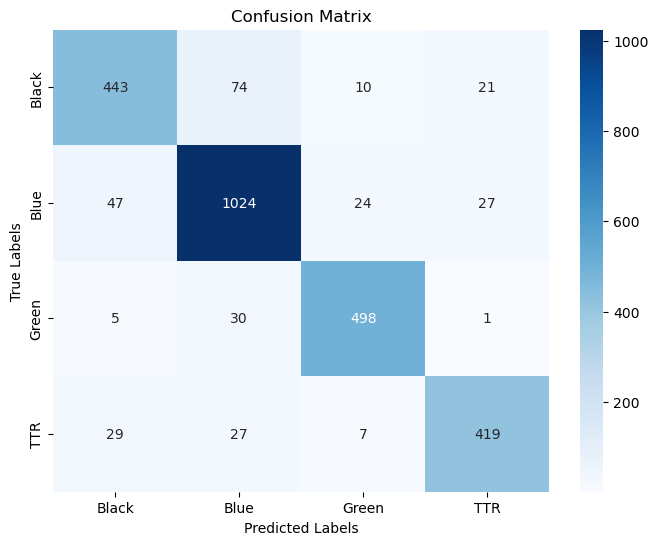

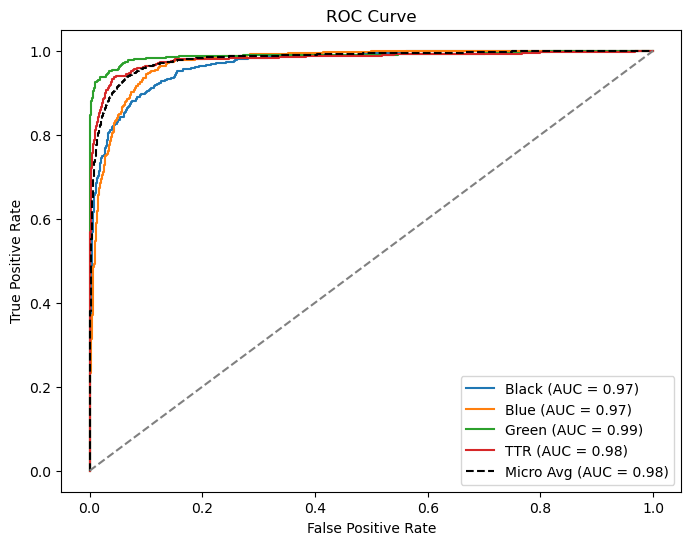

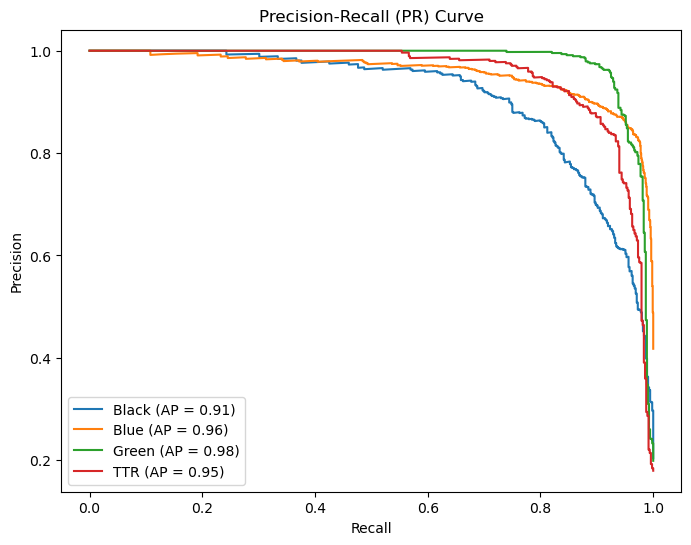

Evaluating model_attention_gated:


C:\Users\Auste\AppData\Local\Temp\ipykernel_36572\598187324.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_attention_gated.load_state_dict(torch.load("experiment


Test Loss: 0.3583, Test Accuracy: 0.8768

Classification Report:
               precision    recall  f1-score   support

       Black       0.80      0.81      0.81       548
        Blue       0.89      0.89      0.89      1122
       Green       0.90      0.93      0.92       534
         TTR       0.90      0.86      0.88       482

    accuracy                           0.88      2686
   macro avg       0.87      0.87      0.87      2686
weighted avg       0.88      0.88      0.88      2686



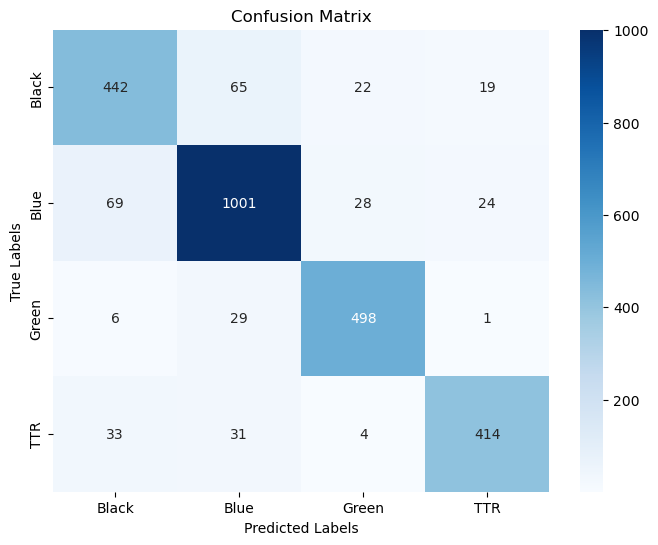

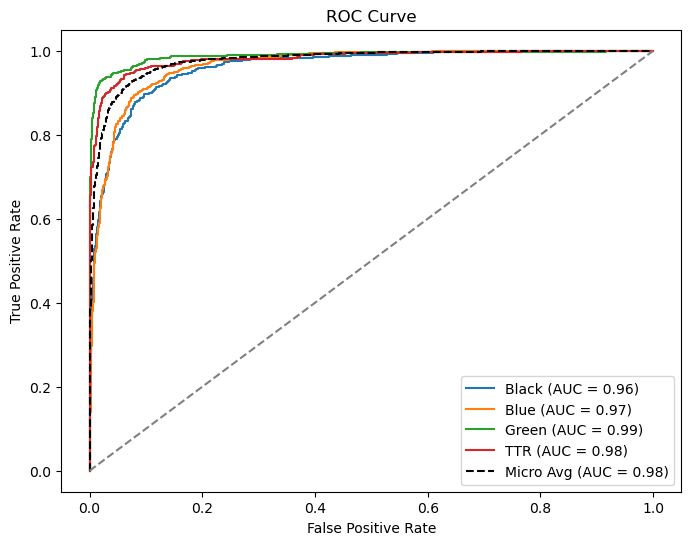

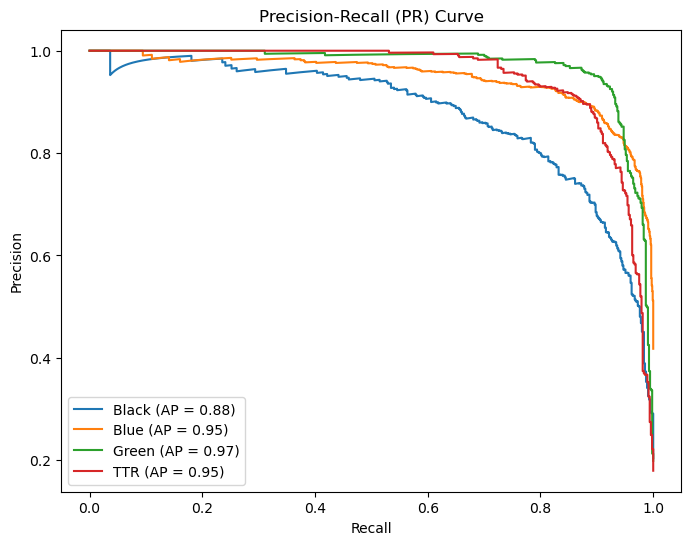

Evaluating model_attention_only:


C:\Users\Auste\AppData\Local\Temp\ipykernel_36572\598187324.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_attention_only.load_state_dict(torch.load("experiment_


Test Loss: 0.3556, Test Accuracy: 0.8801

Classification Report:
               precision    recall  f1-score   support

       Black       0.80      0.80      0.80       548
        Blue       0.88      0.91      0.89      1122
       Green       0.93      0.92      0.92       534
         TTR       0.92      0.87      0.90       482

    accuracy                           0.88      2686
   macro avg       0.88      0.87      0.88      2686
weighted avg       0.88      0.88      0.88      2686



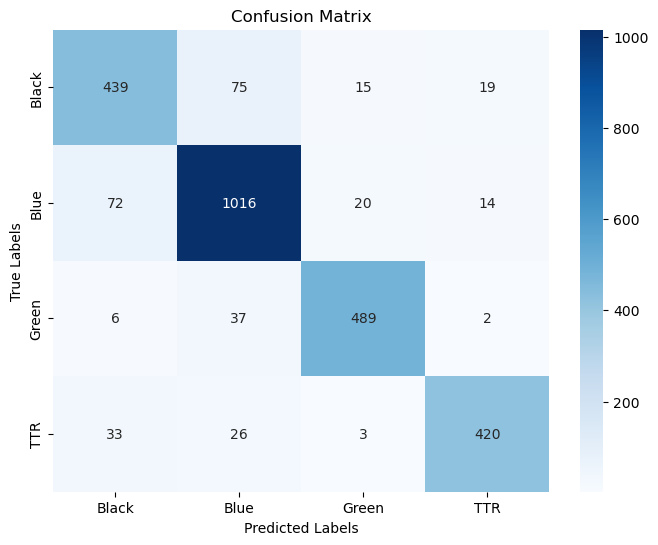

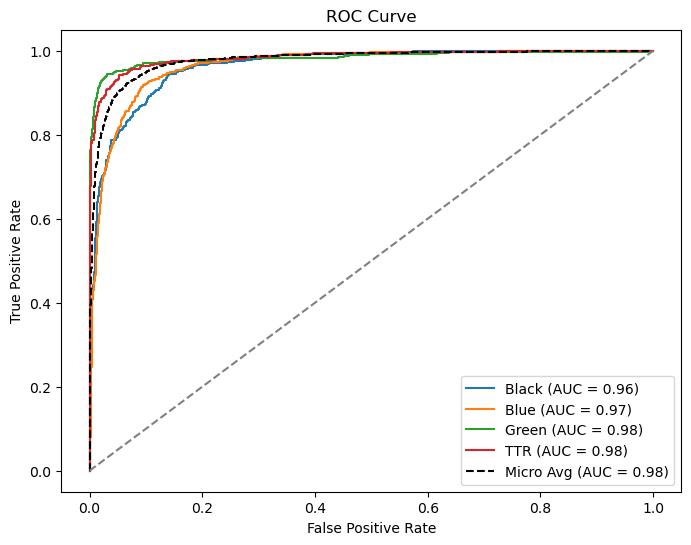

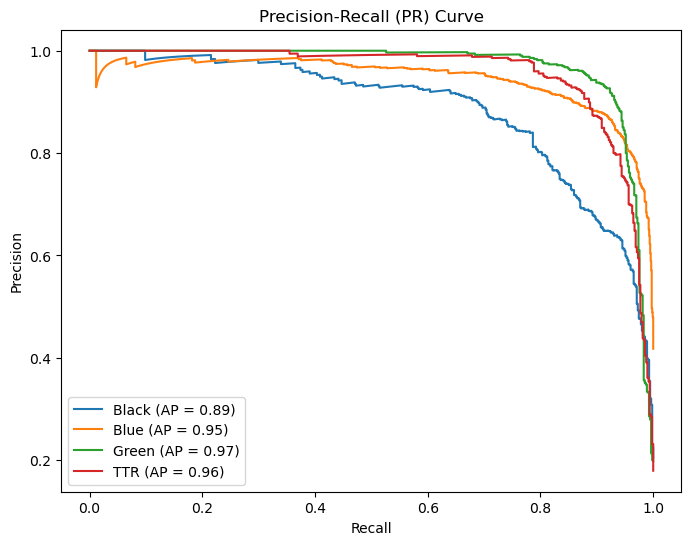

Evaluating model_gated_only:


C:\Users\Auste\AppData\Local\Temp\ipykernel_36572\598187324.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_gated_only.load_state_dict(torch.load("experiment_mult


Test Loss: 0.3769, Test Accuracy: 0.8660

Classification Report:
               precision    recall  f1-score   support

       Black       0.73      0.85      0.79       548
        Blue       0.89      0.88      0.89      1122
       Green       0.92      0.89      0.91       534
         TTR       0.94      0.82      0.87       482

    accuracy                           0.87      2686
   macro avg       0.87      0.86      0.86      2686
weighted avg       0.87      0.87      0.87      2686



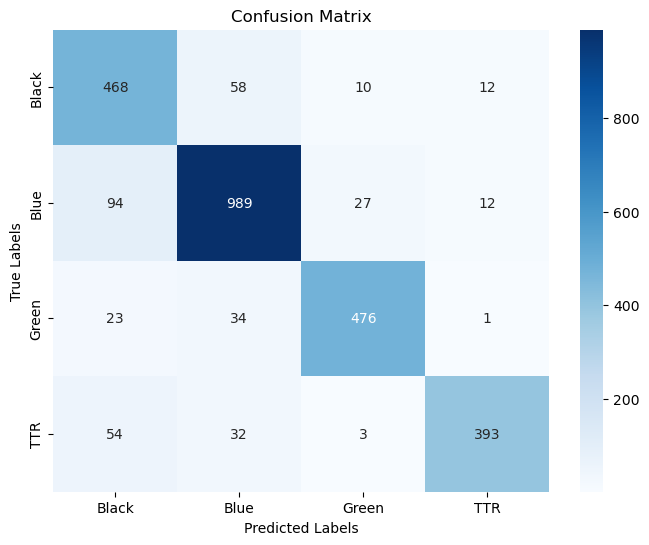

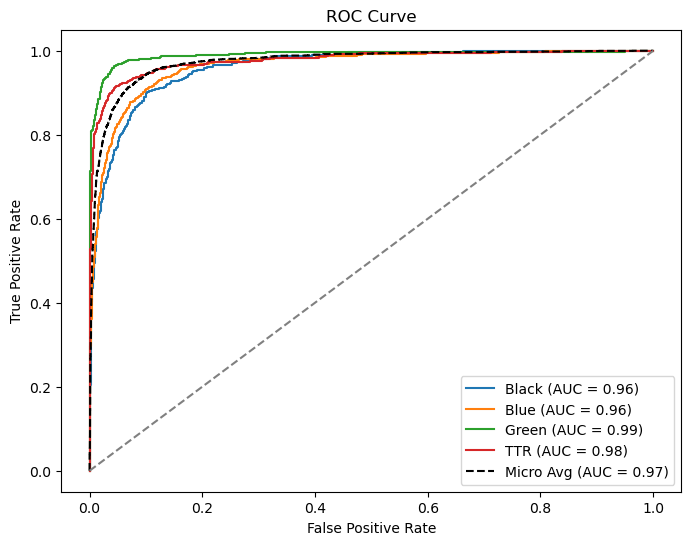

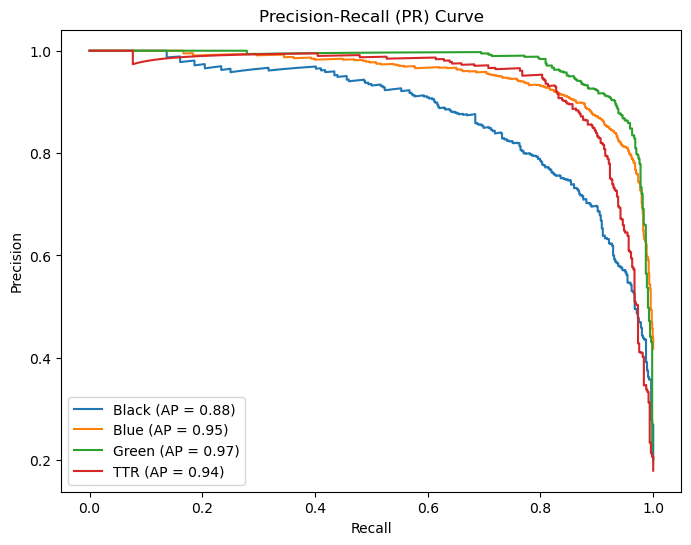

Evaluating model_enetb0_224_simple_concat:


C:\Users\Auste\AppData\Local\Temp\ipykernel_36572\598187324.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_enet.load_state_dict(torch.load("experiment_multimodal


Test Loss: 0.3656, Test Accuracy: 0.8734

Classification Report:
               precision    recall  f1-score   support

       Black       0.79      0.80      0.79       548
        Blue       0.88      0.89      0.89      1122
       Green       0.89      0.93      0.91       534
         TTR       0.93      0.86      0.89       482

    accuracy                           0.87      2686
   macro avg       0.87      0.87      0.87      2686
weighted avg       0.87      0.87      0.87      2686



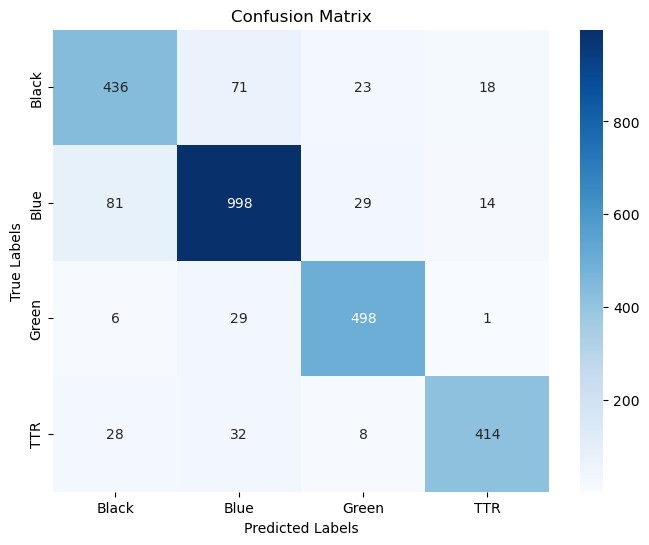

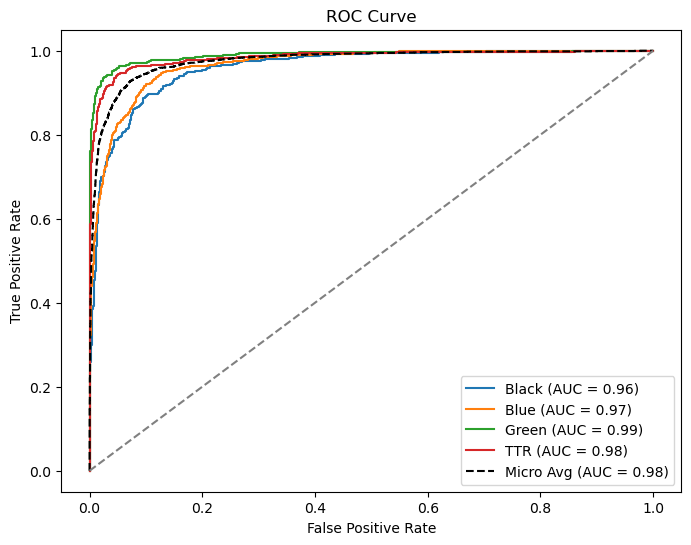

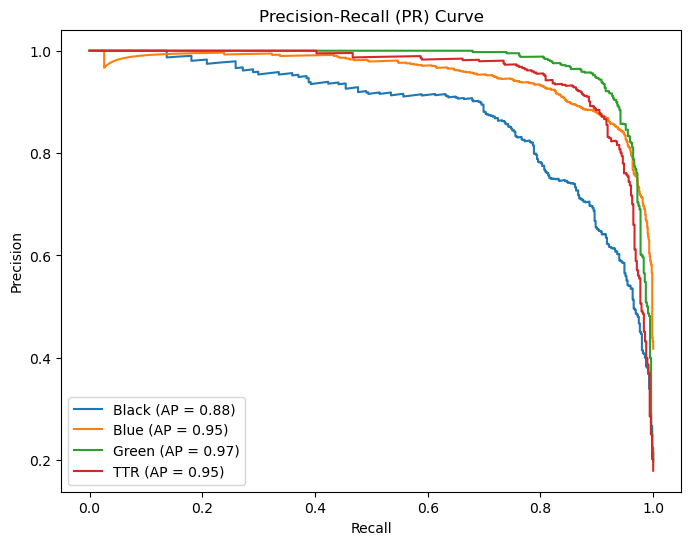

Evaluating model_transformer_fusion:


c:\Users\Auste\anaconda3\envs\envaz\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\Auste\AppData\Local\Temp\ipykernel_36572\598187324.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights


Test Loss: 0.3915, Test Accuracy: 0.8574

Classification Report:
               precision    recall  f1-score   support

       Black       0.77      0.76      0.77       548
        Blue       0.90      0.86      0.88      1122
       Green       0.86      0.94      0.90       534
         TTR       0.86      0.86      0.86       482

    accuracy                           0.86      2686
   macro avg       0.85      0.86      0.85      2686
weighted avg       0.86      0.86      0.86      2686



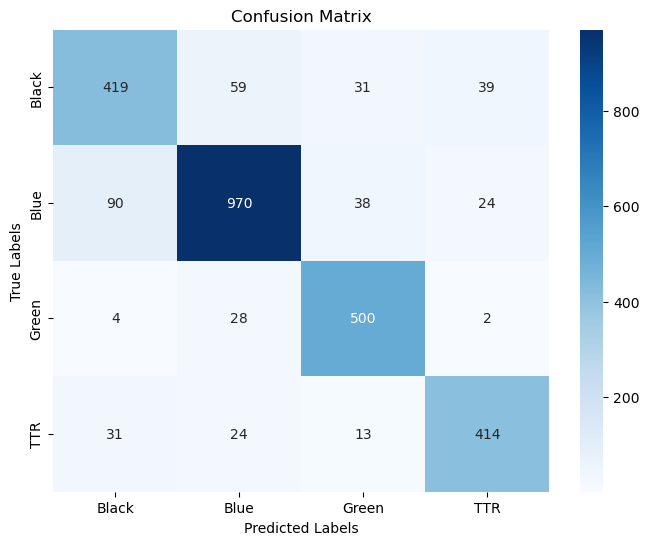

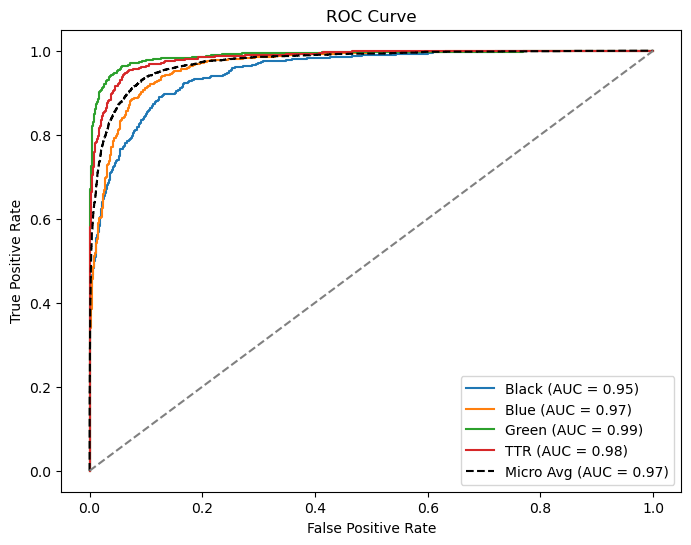

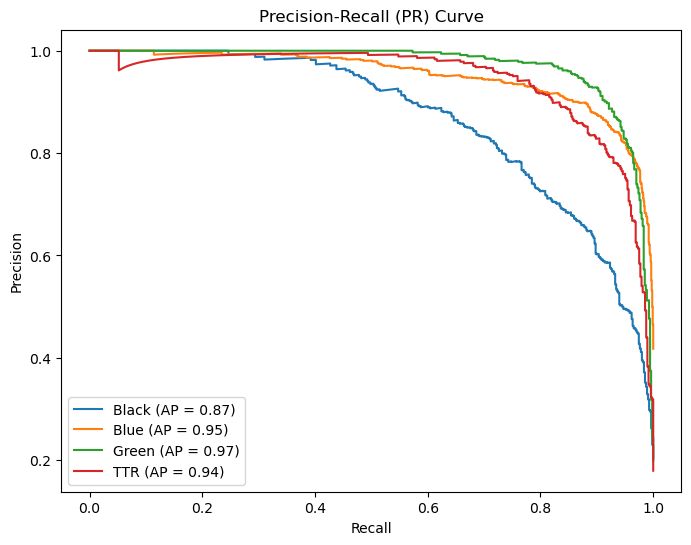

In [ ]:
# ========================================= RUN TESTING & METRICS ================================================

class_labels = ["Black", "Blue", "Green", "TTR"]

# Assignment 2: Control
print("Evaluating Assignment 2 Model as control:")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalClassifier(num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load("multimodal_transformer_fold_1.pth"))

test_accuracy, test_report, test_roc_auc, test_pr_auc = test_model_with_metrics(model, test_loader, device, class_labels)


# #Attention Gated
print("Evaluating model_attention_gated:")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_attention_gated = MultimodalClassifierAttentionGated(num_classes=NUM_CLASSES).to(device)
model_attention_gated.load_state_dict(torch.load("experiment_multimodal_attention_gated_fusion_fold_2.pth"))

test_accuracy, test_report, test_roc_auc, test_pr_auc = test_model_with_metrics(model_attention_gated, test_loader, device, class_labels)


#Attention Only
print("Evaluating model_attention_only:")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_attention_only = MultimodalClassifierAttentionOnly(num_classes=NUM_CLASSES).to(device)
model_attention_only.load_state_dict(torch.load("experiment_multimodal_attention_only_fold_5.pth"))

test_accuracy, test_report, test_roc_auc, test_pr_auc = test_model_with_metrics(model_attention_only, test_loader, device, class_labels)

#Gated Only
print("Evaluating model_gated_only:")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gated_only = MultimodalClassifierGatedOnly(num_classes=NUM_CLASSES).to(device)
model_gated_only.load_state_dict(torch.load("experiment_multimodal_gated_only_fold_5.pth"))

test_accuracy, test_report, test_roc_auc, test_pr_auc = test_model_with_metrics(model_gated_only, test_loader, device, class_labels)

#Enetb0 224 simple concat
print("Evaluating model_enetb0_224_simple_concat:")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_enet = MultimodalClassifierEnet(num_classes=NUM_CLASSES).to(device)
model_enet.load_state_dict(torch.load("experiment_multimodal_enetb0_224_simple_concat_fold_5.pth"))

test_accuracy, test_report, test_roc_auc, test_pr_auc = test_model_with_metrics(model_enet, test_loader, device, class_labels)

#Transformer Fusion
print("Evaluating model_transformer_fusion:")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_transformer = MultimodalClassifierTransformerFusion(num_classes=NUM_CLASSES).to(device)
model_transformer.load_state_dict(torch.load("experiment_multimodal_transformer_fusion_fold_2.pth"))

test_accuracy, test_report, test_roc_auc, test_pr_auc = test_model_with_metrics(model_transformer, test_loader, device, class_labels)

